In [1]:

import argparse
import logging
import os
import shlex
import sys
import pdb
from pathlib import Path
import time
import wandb
import traceback
import torch
import numpy as np
import glob

# to get eccodes working on Ubuntu 20.04
# os.environ["LD_PRELOAD"] = '/usr/lib/x86_64-linux-gnu/libffi.so.7'
# in shell : export LD_PRELOAD=/usr/lib/x86_64-linux-gnu/libffi.so.7
os.putenv("LD_PRELOAD", "/usr/lib/x86_64-linux-gnu/libffi.so.7")
import ecmwflibs
import cfgrib

#if shipped as module, include in S2S_on_SFNO and remove absolute import to relative .inputs etc. . Also move main inside -> __main__.py
from S2S_on_SFNO.inputs import available_inputs
from S2S_on_SFNO.Models.models import Timer, available_models, load_model #########
from S2S_on_SFNO.outputs import available_outputs

from S2S_on_SFNO.Models.train import  ERA5_galvani
from datetime import datetime
from torch.utils.data import DataLoader
import xarray as xr
from calendar import isleap

In [2]:
import matplotlib.pyplot as plt

In [3]:
args = {'test': False, 'model_type': 'sfno', 'model_version': 'film', 'film_gen_type': 'gcn_custom', 'assets': '/mnt/qb/work2/goswami0/gkd965/Assets/sfno', 'film_weights': None, 'sfno_weights': None, 'assets_sub_directory': 'S2S_on_SFNO/Assets', 'path': '/home/goswami/gkd965/MasterML/S2S_on_SFNO/outputs/sfno/leadtime_240_startDate_-112_createdOn_20240416T1132.grib', 'num_threads': 1, 'only_gpu': False, 'cpu': False, 'expver': None, 'class_': None, 'metadata': {}, 'model_args': None, 'assets_list': False, 'fields': False, 'eval_models_autoregressive': True, 'eval_checkpoint_path': '/mnt/qb/work2/goswami0/gkd965/checkpoints/lemon-breeze-29', 'eval_skip_checkpoints': 0, 'download_assets': False, 'input': 'cds', 'input_store': None, 'file': None, 'era5_path': '/mnt/qb/goswami/data/era5', 'archive_requests': None, 'retrieve_requests': False, 'requests_extra': None, 'json': False, 'lead_time': 240, 'date': '-1', 'time': 12, 'output': 'grib', 'output_variables': './S2S_on_SFNO/outputs/output-variables.json', 'dump_provenance': False, 'hindcast_reference_year': None, 'staging_dates': None,'run':False, 'train': False, 'trainingset_start_year': 1959, 'trainingset_end_year': 2019, 'validationset_start_year': 2019, 'validationset_end_year': 2022, 'validation_interval': 150, 'save_checkpoint_interval': 10, 'validation_epochs': 3, 'multi_step_validation': 3, 'multi_step_training': 0, 'training_step_skip': 0, 'val_loss_threshold': 0.4, 'trainingdata_path': '/mnt/qb/goswami/data/era5/weatherbench2/1959-2023_01_10-wb13-6h-1440x721_with_derived_variables.zarr', 'training_workers': 0, 'batch_size': 1, 'learning_rate': 0.001, 'scheduler_type': 'CosineAnnealingWarmRestarts', 'scheduler_horizon': 2000, 'save_path': '/mnt/qb/work2/goswami0/gkd965/checkpoints/sfno_film_gcn_custom_20240416T1132', 'debug': True, 'wandb': False, 'wandb_resume': None, 'notes': None, 'tags': None, 'advanced_logging': False, 'timestr': '20240416T1132'}

In [4]:
# args['eval_checkpoint_path'] = s
args['auto_regressive_steps'] = 3
args['film_gen_type'] = "gcn" #gcn #gcn_custom
args['eval_checkpoint_path'] = '/mnt/qb/work2/goswami0/gkd965/checkpoints/lemon-breeze-29'
args['validation_epochs'] = 3

In [5]:
film_model = load_model(args["model_type"], args)
checkpoint_list = np.array(sorted(glob.glob(os.path.join(args["eval_checkpoint_path"],"checkpoint_*")),key=len)) 
#[save_path+'checkpoint_sfno_latest_epoch={}.pkl'.format(i) for i in range(0,110,20)]#12930
checkpoint_list = checkpoint_list[3:5:(args["eval_skip_checkpoints"]+1)]
print("loading ",len(checkpoint_list), " checkpoints from ", args["eval_checkpoint_path"])
#sfno

args["model_version"] = "release"
sfno = load_model('sfno', args)
# model.auto_regressive_skillscore(checkpoint_list,args.multi_step_validation,args.save_path,sfno=sfno)

outputting only variables:  ['10u', '10v', '2t', 'sp', 'msl', 't850', 'u1000', 'v1000', 'z1000', 'u850', 'v850', 'z850', 'u500', 'v500', 'z500', 't500', 'z50', 'r500', 'r850', 'tcwv']
loading  2  checkpoints from  /mnt/qb/work2/goswami0/gkd965/checkpoints/lemon-breeze-29
outputting only variables:  ['10u', '10v', '2t', 'sp', 'msl', 't850', 'u1000', 'v1000', 'z1000', 'u850', 'v850', 'z850', 'u500', 'v500', 'z500', 't500', 'z50', 'r500', 'r850', 'tcwv']


In [6]:
LOG = logging.getLogger(__name__)
try :
    sfno.model.load_state_dict(torch.load(checkpoint_list[0], map_location=sfno.device)["model_state"])
except RuntimeError as e:
    LOG.error(e)
    print("--- !! ---")
    print("loading state dict with strict=False, please verify if the right model is loaded and strict=False is desired")
    print("--- !! ---")
    sfno.model.load_state_dict(torch.load(checkpoint_list[0])["model_state"],strict=False)

Error(s) in loading state_dict for FourierNeuralOperatorNet:
	Unexpected key(s) in state_dict: "film_gen.conv1.bias", "film_gen.conv1.lin.weight", "film_gen.conv_layers.0.bias", "film_gen.conv_layers.0.lin.weight", "film_gen.conv_layers.1.bias", "film_gen.conv_layers.1.lin.weight", "film_gen.conv_layers.2.bias", "film_gen.conv_layers.2.lin.weight", "film_gen.heads_gamma.0.weight", "film_gen.heads_gamma.0.bias", "film_gen.heads_beta.0.weight", "film_gen.heads_beta.0.bias". 


--- !! ---
loading state dict with strict=False, please verify if the right model is loaded and strict=False is desired
--- !! ---


In [7]:
weigths = torch.load(checkpoint_list[0])["model_state"]
# weigths

In [11]:
pp = torch.load(checkpoint_list[0])

In [ ]:
# pp['hyperparameters']

In [ ]:
# for k,v in pp['hyperparameters'].items():print(k,":",v)

In [25]:
# for k in pp['model_state'].keys():print(k)

In [8]:
film_model.load_statistics(args["film_gen_type"])
        
dataset_validation = ERA5_galvani(
    film_model,
    path=args["trainingdata_path"], 
    start_year=args["validationset_start_year"],
    end_year=args["validationset_end_year"],
    auto_regressive_steps=args["auto_regressive_steps"])

validation_loader = DataLoader(dataset_validation,shuffle=True,num_workers=args["training_workers"], batch_size=args["batch_size"])
loss_fn = torch.nn.MSELoss()#reduction='none'

# load climatology reference
basePath = "/mnt/qb/work2/goswami0/gkd965/"
variable = "10m_u_component_of_wind"
mean_files = {
    '10m_u_component_of_wind':'hourofyear_mean_for_10m_u_component_of_wind_from_1979_to_2017created_20240123-0404.nc',
    '10m_v_component_of_wind':'hourofyear_mean_for_10m_v_component_of_wind_from_1979_to_2019created_20231211-1339.nc',
    '2m_temperature':'hourofyear_mean_for_2m_temperature_from_1979_to_2017created_20240123-0343.nc',
    'total_column_water_vapour':'hourofyear_mean_for_total_column_water_vapour_from_1979_to_2017created_20240123-0415.nc'

}
mean_file = os.path.join(basePath,"climate",mean_files[variable])
ds_ref  = xr.open_dataset(mean_file)#.to_array().squeeze()[:min_step*6:6]

if sfno:
    sfno.load_statistics()
    sfno_model = sfno.load_model(sfno.checkpoint_path)
    sfno_model.eval()

validation_loss_curve = {}
for cp_idx, checkpoint in enumerate(checkpoint_list):
    # if cp_idx < 2: continue
    print(" --- checkpoint : ",checkpoint," --- ")
    model = film_model.load_model(checkpoint)
    model.eval()
    with torch.no_grad():
        val_log = {}
        val_loss = {}
        
        # For loop over validation dataset, calculates the validation loss mean for number of kwargs["validation_epochs"]
        skill_score_model_list = []
        skill_score_sfno_list = []
        # set seed to keep shuffled batches for all models the same
        torch.manual_seed(1)
        for val_epoch, val_data in enumerate(validation_loader):
            # Calculates the validation loss for autoregressive model evaluation
            # if self.auto_regressive_steps = 0 the dataloader only outputs 2 datapoint 
            # and the for loop only runs once (calculating the ordinary validation loss with no auto regressive evaluation
            skill_score_model = []
            skill_score_sfno  = []
            for val_idx in range(len(val_data)-1):
                # skip leap year feb 29 and subtract leap day from index
                time = val_data[val_idx][2].item()
                if isleap(int(str(time)[:4])) and str(time)[4:8] == "02029" : break
                # calculates the days since the 1.1. of the same year
                yday = datetime.strptime(str(time), '%Y%m%d%H').timetuple().tm_yday
                ref_idx = ((yday-1)*24 + int(str(time)[-2:]))#//6
                # print(time, " - ",ref_idx)
                # if we are in a leap year we subtract the leap day 29.2. from reference index to get the correct idx for clim ref
                if isleap(int(str(time)[:4])) and int(str(time)[4:6]) > 2 : ref_idx = ref_idx - 24
                    
                if val_idx == 0: val_input_era5 = film_model.normalise(val_data[val_idx][0]).to(film_model.device)
                else: val_input_era5 = outputs
                val_input_sst  = film_model.normalise_film(val_data[val_idx][1]).to(film_model.device)
                #
                # loss sfno 
                #    all (normalised) 0.3
                #    all              6811386
                #    u10 (normalised) 0.8
                #    u10              4460
                break
            break
        break
                # outputs = model(val_input_era5,val_input_sst,1)
                # # MSE real space
                # # val_g_truth_era5 = val_data[val_idx+1][0].squeeze()[self.ordering_reverse[variable]]
                # # output_var = self.normalise(outputs.to("cpu"),reverse=True).squeeze()[self.ordering_reverse[variable]]
                # # val_loss_value = loss_fn(output_var, val_g_truth_era5)
                # # MSE normalised space
                # val_g_truth_era5 = film_model.normalise(val_data[val_idx+1][0]).to(film_model.device).squeeze()[film_model.ordering_reverse[variable]]
                # output_var = outputs.squeeze()[film_model.ordering_reverse[variable]]
                # val_loss_value = loss_fn(output_var, val_g_truth_era5)
                
                # ref_img = torch.tensor(ds_ref.isel(time=ref_idx).to_array().squeeze().to_numpy())
        #         break
        #     break
        # break
            #     ref_loss_value = loss_fn(ref_img,val_g_truth_era5)
            #     skill_score  = 1 - val_loss_value/ref_loss_value
            #     skill_score_model.append(skill_score.item())
            #     # calculate sfno skill score once
            #     if sfno:
            #         if val_idx == 0: sfno_input_era5 = sfno.normalise(val_data[val_idx][0]).to(sfno.device)
            #         else: sfno_input_era5 = sfno_output
            #         sfno_output = sfno_model(sfno_input_era5)
            #         sfno_output_var = sfno.normalise(sfno_output.to("cpu"),reverse=True).squeeze()[sfno.ordering_reverse[variable]]
            #         sfno_val_loss_value = loss_fn(sfno_output_var, val_g_truth_era5)
            #         sfno_skill_score  = 1 - sfno_val_loss_value/ref_loss_value
            #         skill_score_sfno.append(sfno_skill_score.item())
            
            # skill_score_model_list.append(skill_score_model)
            # if sfno: skill_score_sfno_list .append(skill_score_sfno)
            # for i in range(len(skill_score_model)):
            #     print("auto regress ",i,":")
            #     print(" -  model ",round(skill_score_model[i],4))
            #     if sfno: print(" -  sfno ",round(skill_score_sfno[i],4))

            # # Do we need Checkpoints?

            # # end of validation 
            # if val_epoch > args["validation_epochs"]:
            #     cp_name = checkpoint.split("/")[-1].split(".")[0]
            #     savefile=os.path.join(save_path,"{}_skill_score_{}.pkl")
            #     np.save(savefile.format("model",cp_name),skill_score_model_list)
            #     if sfno: np.save(savefile.format("","sfno"),skill_score_sfno_list)
            #     print("done:")
            #     scml = np.array(skill_score_model_list)
            #     scsl = np.array(skill_score_sfno_list)
            #     mean_scml = scml.mean(axis=0)
            #     std_scml  = scml.std(axis=0)
            #     mean_scsl = scsl.mean(axis=0)
            #     std_scsl  = scsl.std(axis=0)
            #     for i in range(len(skill_score_model_list[0])):
            #         print("auto regress ",i,":")
            #         print(" -  mean model skill ",round(mean_scml[i],4),"+/-",round(std_scml[i],4) )
            #         if sfno: print(" -  mean sfno skill  ",round(mean_scsl[i],4),"+/-",round(std_scsl[i],4) )
                
            #     # do not to need to recalculate sfno skill score
            #     sfno = False
            #     break

Using years:  2019  -  2022  (total length:  4383 ) (availabe date range:  1959 - 2022 )

 --- checkpoint :  /mnt/qb/work2/goswami0/gkd965/checkpoints/lemon-breeze-29/checkpoint_sfno_film_gcn_epoch=1500.pkl  --- 


In [33]:
cmap=plt.get_cmap('hot')
rgba = cmap(0.5)
rgba

(1.0, 0.359314099938117, 0.0, 1.0)

(73,)


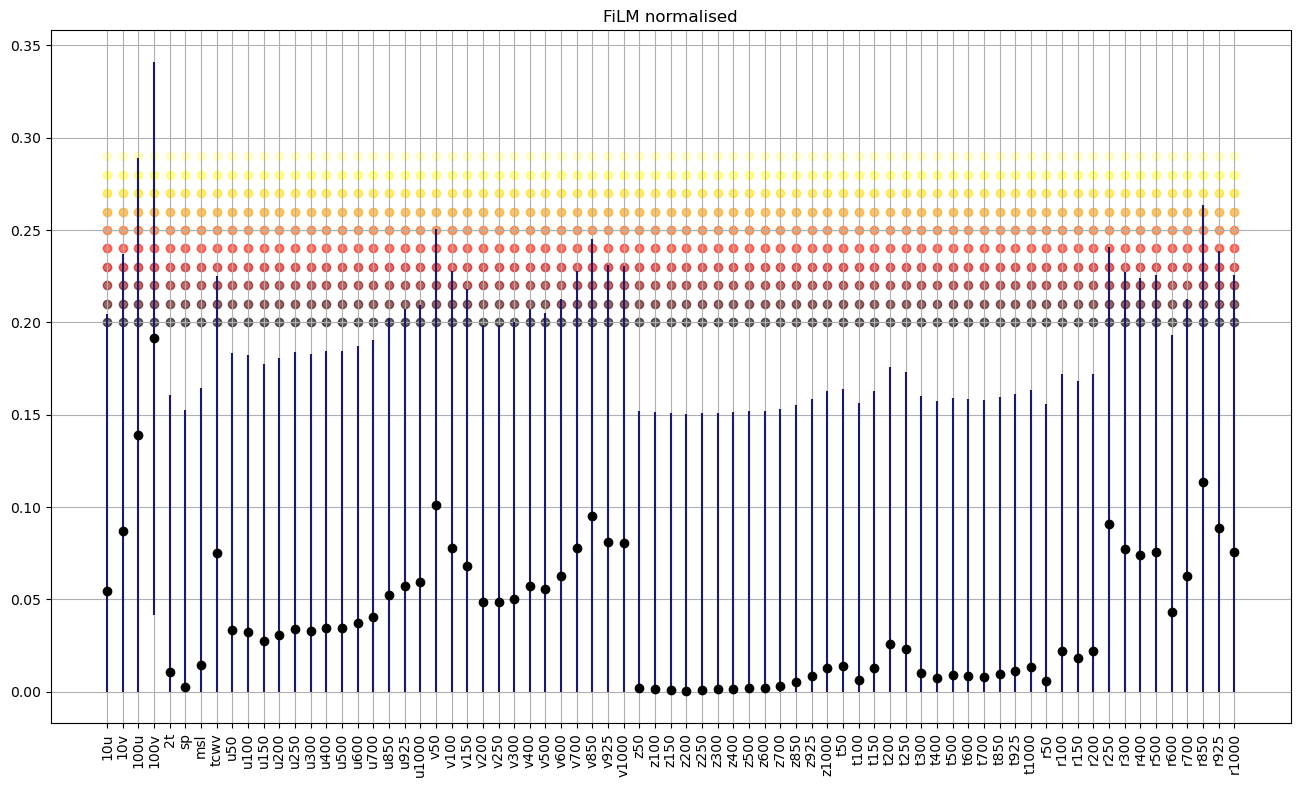

In [42]:
with torch.no_grad():
    loss_fn_pervar = torch.nn.MSELoss(reduction='none')
    outputs = model(val_input_era5,val_input_sst,1)
    val_g_truth_era5 = film_model.normalise(val_data[val_idx+1][0]).to(film_model.device)
    loss = loss_fn_pervar(outputs, val_g_truth_era5).mean(dim=(0,2,3))
    loss = loss.to("cpu")
    std = np.ones_like(loss)*0.15
    yerr_bottom = std.copy()
    yerr_bottom_div = loss.numpy() - yerr_bottom 
    yerr_bottom_div[yerr_bottom_div>0]=0
    print(yerr_bottom_div.shape)
    yerr_bottom = yerr_bottom + yerr_bottom_div
    yerr = [yerr_bottom,std]
    fig, ax = plt.subplots(figsize=(16,9))
    plt.title("FiLM normalised")
    ax.errorbar(range(len(loss)),loss,yerr=yerr,fmt='o', lolims=0.,c='black',ecolor='midnightblue')
    for i in range(10):
        ax.scatter(range(len(loss)),np.ones(len(loss))*(0.2+i/100),marker='o',alpha=0.6,color=cmap(0+0.1*i))
    plt.xticks(np.arange(len(film_model.ordering)), film_model.ordering, rotation='vertical')
    plt.grid()
    # ax.set_xticklabels()


In [22]:
np.arange(len(film_model.ordering))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72])

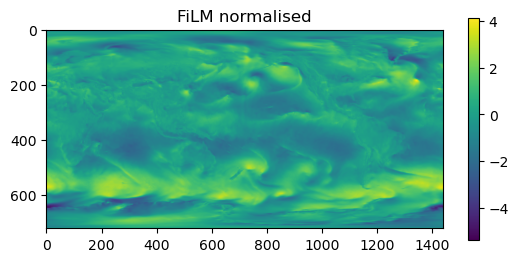

In [8]:
with torch.no_grad():
    outputs = model(val_input_era5,val_input_sst,1)
    outputs = outputs.squeeze()[film_model.ordering_reverse[variable]]
    plt.title("FiLM normalised")
    plt.imshow(outputs.to("cpu").detach().numpy())
    plt.colorbar(shrink=0.6)

    # #
    # val_g_truth_era5 = val_data[val_idx+1][0].squeeze()[self.ordering_reverse[variable]]
    # val_loss_value = loss_fn(output_var, val_g_truth_era5)

loss:  1.681235671043396


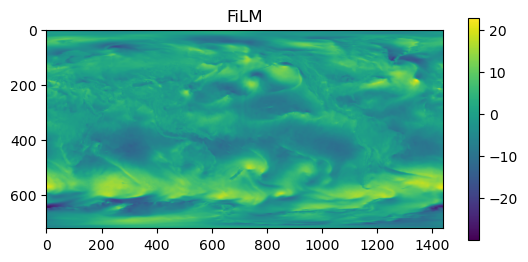

In [9]:
with torch.no_grad():
    outputs = model(val_input_era5,val_input_sst,1)
    outputs = film_model.normalise(outputs.to("cpu"),reverse=True)
    outputs = outputs.squeeze()[film_model.ordering_reverse[variable]]
    plt.title("FiLM")
    plt.imshow(outputs.to("cpu").detach().numpy())
    plt.colorbar(shrink=0.6)
    
    #
    val_g_truth_era5 = val_data[val_idx+1][0].squeeze()[film_model.ordering_reverse[variable]]
    val_loss_value = loss_fn(outputs, val_g_truth_era5)
    print("loss: ",val_loss_value.item())

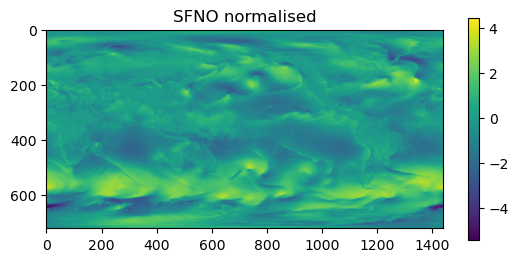

In [10]:
with torch.no_grad():
    outputs = model(val_input_era5,val_input_sst,0)
    outputs = outputs.squeeze()[film_model.ordering_reverse[variable]]
    plt.title("SFNO normalised")
    plt.imshow(outputs.to("cpu").detach().numpy())
    plt.colorbar(shrink=0.6)

loss:  0.8615882396697998


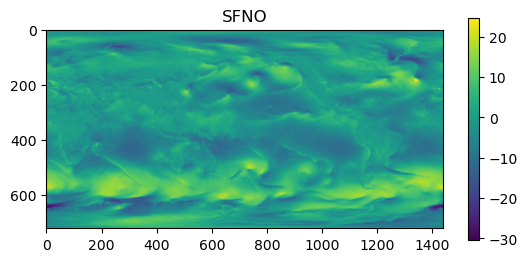

In [11]:
with torch.no_grad():
    outputs = model(val_input_era5,val_input_sst,0)
    outputs = film_model.normalise(outputs.to("cpu"),reverse=True)
    outputs = outputs.squeeze()[film_model.ordering_reverse[variable]]
    plt.title("SFNO")
    plt.imshow(outputs)
    plt.colorbar(shrink=0.6)
    
    #
    val_g_truth_era5 = val_data[val_idx+1][0].squeeze()[film_model.ordering_reverse[variable]]
    val_loss_value = loss_fn(outputs, val_g_truth_era5)
    print("loss: ",val_loss_value.item())

loss:  17.4825382232666


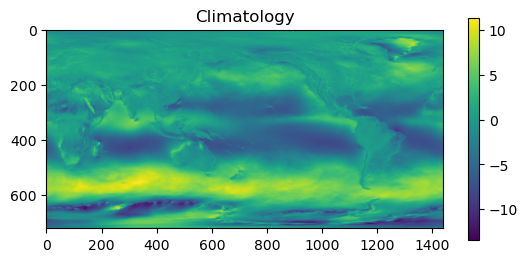

In [41]:
with torch.no_grad():
    ref_img = torch.tensor(ds_ref.isel(time=ref_idx).to_array().squeeze().to_numpy())
    plt.title("Climatology")
    plt.imshow(ref_img)
    plt.colorbar(shrink=0.6)
        
    #
    val_g_truth_era5 = val_data[val_idx+1][0].squeeze()[film_model.ordering_reverse[variable]]
    val_loss_value = loss_fn(ref_img, val_g_truth_era5)
    print("loss: ",val_loss_value.item())


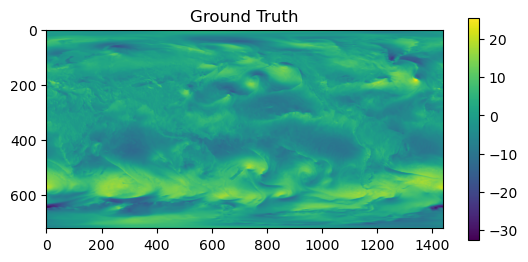

In [22]:
val_g_truth_era5 = val_data[val_idx+1][0].squeeze()[film_model.ordering_reverse[variable]]
plt.title("Ground Truth")
plt.imshow(val_g_truth_era5)
plt.colorbar(shrink=0.6)


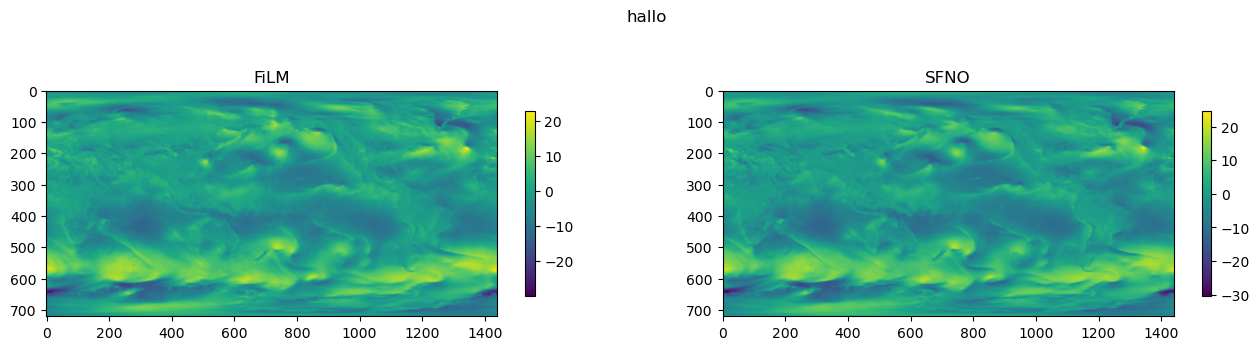

In [15]:
fig,ax = plt.subplots(1,2,figsize=(16,4))
with torch.no_grad():
    outputs = model(val_input_era5,val_input_sst,1)
    outputs = film_model.normalise(outputs.to("cpu"),reverse=True)
    outputs = outputs.squeeze()[film_model.ordering_reverse[variable]]
    ax[0].set_title("FiLM")
    im0 = ax[0].imshow(outputs.to("cpu").detach().numpy())
    fig.colorbar(im0, ax=ax[0],shrink=0.6)

    
    outputs = model(val_input_era5,val_input_sst,0)
    outputs = film_model.normalise(outputs.to("cpu"),reverse=True)
    outputs = outputs.squeeze()[film_model.ordering_reverse[variable]]
    ax[1].set_title("SFNO")
    im1 = ax[1].imshow(outputs)
    fig.colorbar(im1, ax=ax[1],shrink=0.6)

    # val_g_truth_era5 = val_data[val_idx+1][0].squeeze()[film_model.ordering_reverse[variable]]
    # ax[2].set_title("Ground Truth")
    # im2 = ax[2].imshow(val_g_truth_era5)
    # fig.colorbar(im2, ax=ax[2],shrink=0.3)

    fig.suptitle("hallo")



    # ax[0].set_colorbar(shrink=0.6)
    # cax = fig.add_axes([0.27, 0.8, 0.5, 0.05])
    # fig.colorbar(im1, cax=cax, orientation='horizontal')